# Big Tech Stock Predictor

The goal of this project is to use AAPL stock as a tool to leverage different machine learning and deep learning regressors to predict the stock price / movement across an array of intervals to see how accurate ML / DL models can be.

**What is being predicted?**

The predicted feature for this research is the adjusted close as this is the standard for comparing price of a security irregardless of security splits / other external factors, and thus this will be the target feature that the regressors will be trying to estimate.

# Data Pre-Processing

In this step, we are preparing the data to be used in training the models.

Note that feature engineering has already been performed manually on this dataset to add in extra columns, and thus the resulting CSV file is already engineered. I added in manually the column for Earnings (0 representing non-earnings the next day and 1 representing an earnings report the following day), and also predicted EPS (earnings per share) and actual EPS columns.

Citation for AAPL stock inital data: https://www.kaggle.com/datasets/evangower/big-tech-stock-prices/?select=AAPL.csv

Citation for Earnings, Predicted and Actual EPS data: https://www.alphaquery.com/stock/AAPL/earnings-history

Note also that our target variable - actual adj close - varies depending on the time frame we are trying to predict as it shifts depending on how far out we are attempting to forecast.

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

df_aapl = pd.read_csv('AAPL.csv')

df_aapl = df_aapl.dropna(subset=['Date'])

# Convert the 'Date' column to datetime type
df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# Extract the timestamp from the datetime and convert it to float
df_aapl['Date'] = df_aapl['Date'].apply(lambda x: x.timestamp())

# Visualization of features

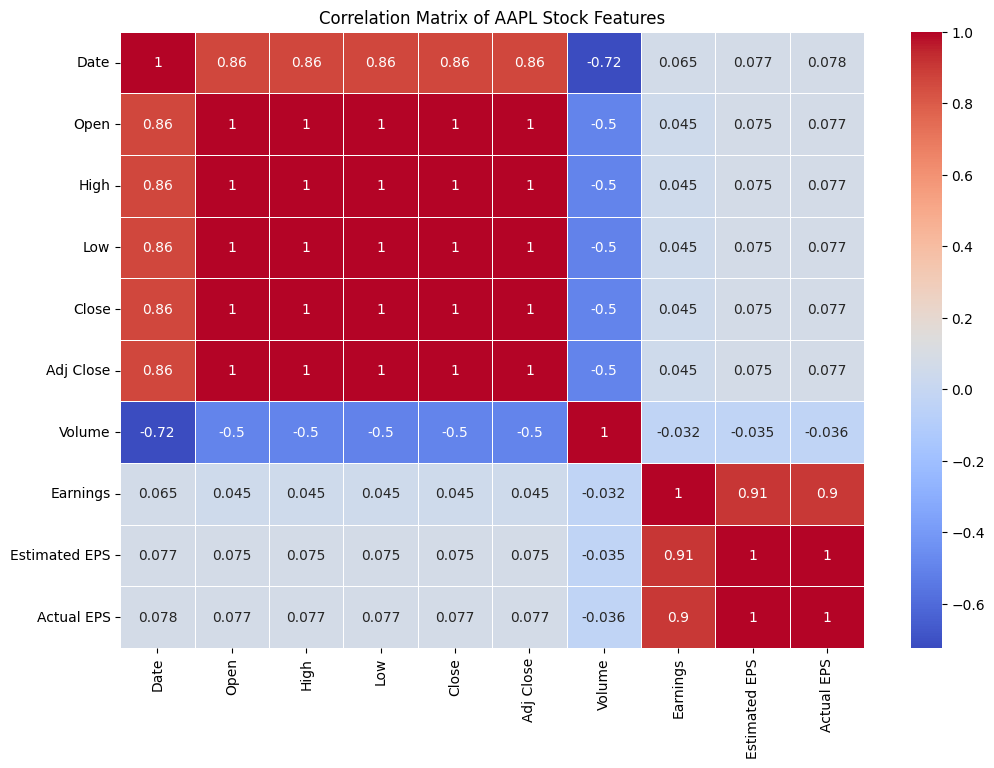

In [18]:
correlation_matrix = df_aapl.corr()

plt.figure(figsize=(12, 8))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)

plt.title('Correlation Matrix of AAPL Stock Features')
plt.show()

# I would like to do a feature seaborn correlation graph to see how correlated features are. Maybe PCA analysis too?

# Linear Regression Model

**Next Day Prediction (non-earnings eve)**

Uses non-earnings eve rows (ie rows where the next day is not an earnings day) to forecast AAPL stock price predictions for the next day

Overall modified Accuracy
0.9713689920127392
Mean Squared Error (adj price in dollars amount off): 2.271537578962682
Custom Predictions:
[53.99463099]
Accuracy of Custom Prediction:
[95.60092208]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


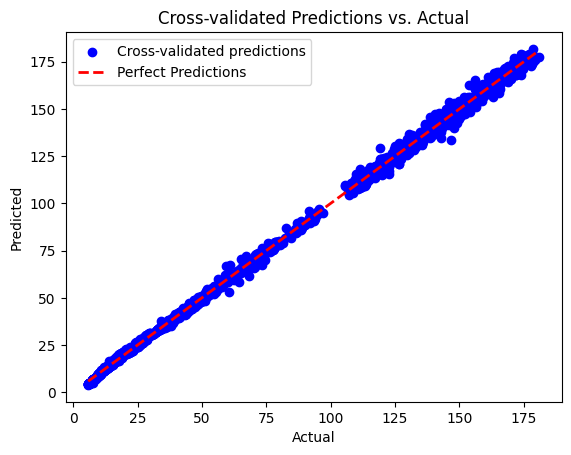

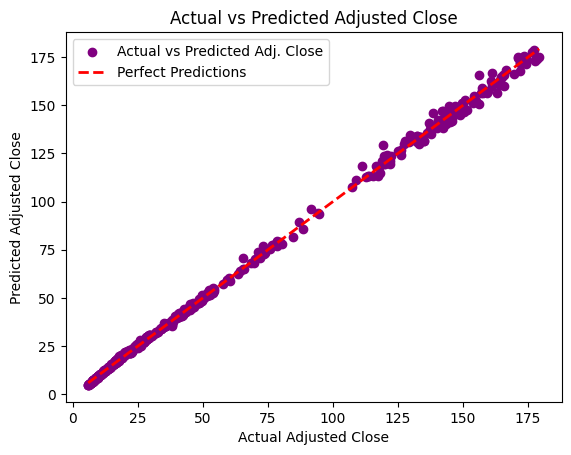

In [19]:
# Assign the target adj close (what we are trying to predict)
# to be the subsequent row's adjusted close on the following day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-1)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (10/23/2018)
custom_values = np.array([[53.957500,55.812500,53.674999,55.682499,155071200,0]])

# This would be the next day after the above date (10/24/2018)
actual_adj_value = 51.719452

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 10/23/2018 predicting 10/24/2018)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print("Custom Predictions:")
print(custom_predictions)

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the results of cross-validated predictions
plt.scatter(y_aapl, predicted, color='blue', label='Cross-validated predictions')
plt.plot([y_aapl.min(), y_aapl.max()], [y_aapl.min(), y_aapl.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Cross-validated Predictions vs. Actual')
plt.legend()
plt.show()

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


# Analysis of non-earnings eve results

In the above graphs, we can see a very interested spread of our model's predictions. In the Actual vs Predicted Adjusted Close graph, we can see that the linear regression model is quite accurate at the start of the actual adjusted close price, but as the adjusted close price goes on (and thus time also increases due to correlation), we see that the model is less accurate with its predictions straying further from the perfect prediction trend line. This phenomena also extends to the accuracy of the cross-validated predictions as well, and can be best explained through the increase of market volatility over recent years.

Market volatility will likely become even more prevalent as time goes on, and thus is something that must be accounted for in making predictions. However, it is interesting that its visualization is so readily obvious in the above graphs.

#Next Day Prediction (earnings eve)

<ipython-input-20-4b825896ba88>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(row)
<ipython-input-20-4b825896ba88>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(df_aapl.loc[index + 1])
<ipython-input-20-4b825896ba88>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(row)
<ipython-input-20-4b825896ba88>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(df_aapl.loc[index + 1])
<ipython-input-20-4b825896ba88>:27: FutureWarning: The frame.append method is deprecated and will be removed f

Overall modified Accuracy
0.9629013046006489
Mean Squared Error (adj price in dollars amount off): 14.540673159714526
Custom Predictions:
[54.15378092]
Accuracy of Custom Prediction:
[91.45275498]


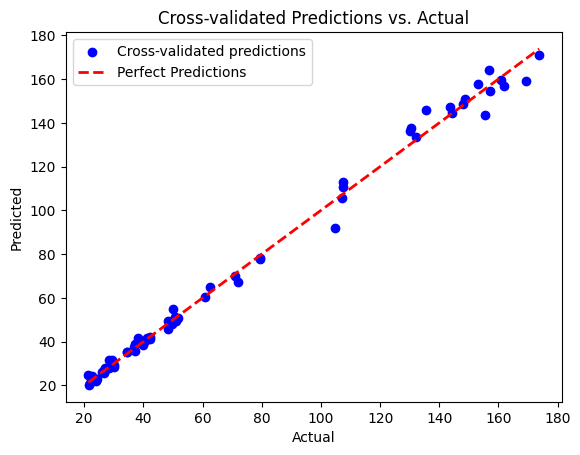

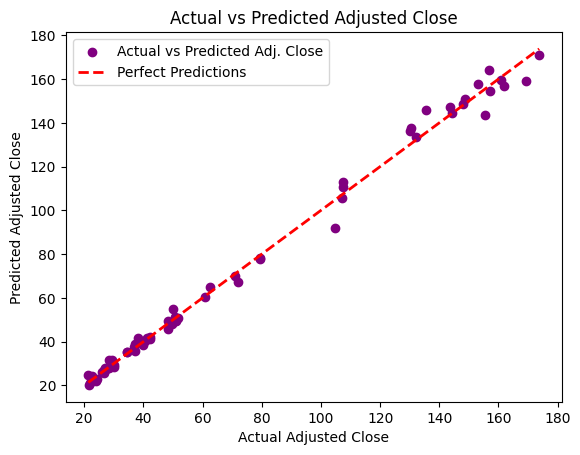

In [20]:
df_aapl = pd.read_csv('AAPL.csv')

df_aapl = df_aapl.dropna(subset=['Date'])

# Convert the 'Date' column to datetime type
# df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# # Extract the timestamp from the datetime and convert it to float
# df_aapl['Date'] = df_aapl['Date'].apply(lambda x: x.timestamp())

# Assign the target adjusted close (ie what we are trying to predict)
# to be the next day's adjusted close
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-1)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Initialize an empty dataframe to store the selected rows (earnings rows and the subsequent row directly after
# so we can see the effect of the earnings results on the stock price the next day)
selected_rows = pd.DataFrame()

# Iterate through the entirety of the aapl dataframe
for index, row in df_aapl.iterrows():
    # Check if the current row has "Earnings" equal to 1
    if row['Earnings'] == 1.0:
        # Append the current row
        selected_rows = selected_rows.append(row)
        # Check if we are still within bounds of the df
        if ((index + 1 < len(df_aapl))):
          # If so, also append the subsequent non-earnings row to our selected rows
          selected_rows = selected_rows.append(df_aapl.loc[index + 1])

# Reset the index of the new DataFrame
selected_rows.reset_index(drop=True, inplace=True)

# Update the aapl df to contain only the selected rows relevant to earnings eve
df_aapl_earn = selected_rows

# Separate the features (X) and target variable (y)
y_aapl = df_aapl_earn['Target Adj Close']

X_aapl = df_aapl_earn.drop(['Adj Close', 'Target Adj Close', 'Date'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame or list of tuples with predicted and actual values
results_df = pd.DataFrame({'Predicted': predicted, 'Actual': y_aapl})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predicted, y_aapl))

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_aapl, predicted)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# takes in open, high, low, close, volume, earnings, expected eps, actual eps
# below is an example value of earnings day eve provided as an example (11/01/2018)
custom_values = np.array([[54.762501,55.590000,54.202499,55.555000,233292800,1,0.7,0.73]])

# This would be the next day after the above date (11/02/2018)
actual_adj_value = 49.889595

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 11/01/2018 predicting 11/02/2018 adj close)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print("Custom Predictions:")
print(custom_predictions)

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the results of cross-validated predictions
plt.scatter(y_aapl, predicted, color='blue', label='Cross-validated predictions')
plt.plot([y_aapl.min(), y_aapl.max()], [y_aapl.min(), y_aapl.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Cross-validated Predictions vs. Actual')
plt.legend()
plt.show()

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()

# Analysis of earnings eve results

Similar to the above non-earnings eve results, we can see that our linear regression model performs much more accurately when the actual adjusted close price is lower, and becomes more erratic as the share price increases, ie time goes on. Besides having much fewer data points to work with, earnings is particularly interesting as it is readily known that even if a company beats earnings estimates, the stock price can still decrease based on the whims of the market and other external factors, thus, achieving accuracy with the linear regression model for this application is difficult but intriguing. As in recent years past, with increased market volatility we can see this trend demonstrated yet again across both the cross-validated prediction and predicted adjusted close vs actual.

#Next Month Stock Prediction (non-earnings)

Note that the shift for the monthly data is not quite as linear as simply shifting over by 1 for the subsequent day due to varying month length. Instead, an average has been taken between different months to use an approximation of the number of market open days that elaspses in a monthly interval. An approximation of 22 market open days between monthly intervals was found to best estimate this shift.


after tail
              Date        Open        High         Low       Close  \
3214  1.665360e+09  140.419998  141.889999  138.570007  140.419998   
3215  1.665446e+09  139.899994  141.350006  138.220001  138.979996   
3216  1.665533e+09  139.130005  140.360001  138.160004  138.339996   
3217  1.665619e+09  134.990005  143.589996  134.369995  142.990005   
3218  1.665706e+09  144.309998  144.520004  138.190002  138.380005   
3219  1.665965e+09  141.070007  142.899994  140.270004  142.410004   
3220  1.666051e+09  145.490005  146.699997  140.610001  143.750000   
3221  1.666138e+09  141.690002  144.949997  141.500000  143.860001   
3222  1.666224e+09  143.020004  145.889999  142.649994  143.389999   
3223  1.666310e+09  142.869995  147.850006  142.649994  147.270004   
3224  1.666570e+09  147.190002  150.229996  146.000000  149.449997   
3225  1.666656e+09  150.089996  152.490005  149.360001  152.339996   
3226  1.666742e+09  150.960007  151.990005  148.039993  149.350006   
3227  1.6

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


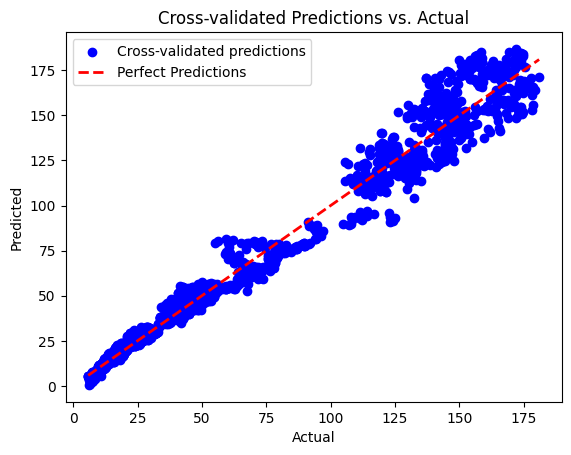

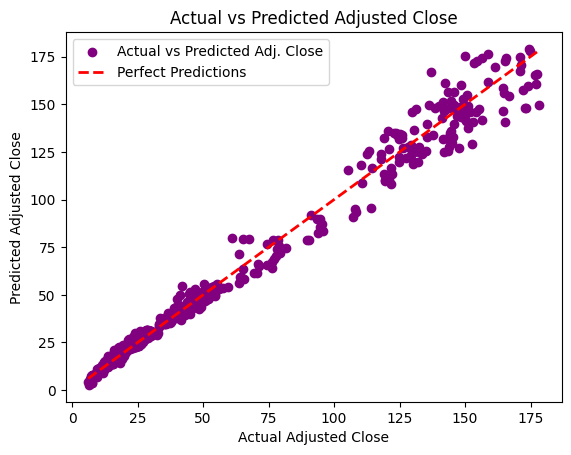

In [21]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

df_aapl = df_aapl.dropna(subset=['Date'])

# Convert the 'Date' column to datetime type
df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# Extract the timestamp from the datetime and convert it to float
df_aapl['Date'] = df_aapl['Date'].apply(lambda x: x.timestamp())

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately 22 business (market open) days later
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-22)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

print("after tail")
print(df_aapl.tail(35))

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (10/23/2018)
custom_values = np.array([[53.957500,55.812500,53.674999,55.682499,155071200,0]])

# This would be the next day after the above date (10/24/2018)
actual_adj_value = 51.719452

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 10/23/2018 predicting 10/24/2018)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print("Custom Predictions:")
print(custom_predictions)

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the results of cross-validated predictions
plt.scatter(y_aapl, predicted, color='blue', label='Cross-validated predictions')
plt.plot([y_aapl.min(), y_aapl.max()], [y_aapl.min(), y_aapl.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Cross-validated Predictions vs. Actual')
plt.legend()
plt.show()

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


#Next Year Stock Prediction (non-earnings)

A year shift should be 22 x 12 = 264 business days?

after tail
            Date        Open        High         Low       Close   Adj Close  \
2986  2021-11-11  148.960007  149.429993  147.679993  147.869995  147.016754   
2987  2021-11-12  148.429993  150.399994  147.479996  149.990005  149.124527   
2988  2021-11-15  150.369995  151.880005  149.429993  150.000000  149.134460   
2989  2021-11-16  149.940002  151.490005  149.339996  151.000000  150.128677   
2990  2021-11-17  151.000000  155.000000  150.990005  153.490005  152.604324   
2991  2021-11-18  153.710007  158.669998  153.050003  157.869995  156.959030   
2992  2021-11-19  157.649994  161.020004  156.529999  160.550003  159.623581   
2993  2021-11-22  161.679993  165.699997  161.000000  161.020004  160.090866   
2994  2021-11-23  161.119995  161.800003  159.059998  161.410004  160.478638   
2995  2021-11-24  160.750000  162.139999  159.639999  161.940002  161.005569   
2996  2021-11-26  159.570007  160.449997  156.360001  156.809998  155.905167   
2997  2021-11-29  159.369995 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


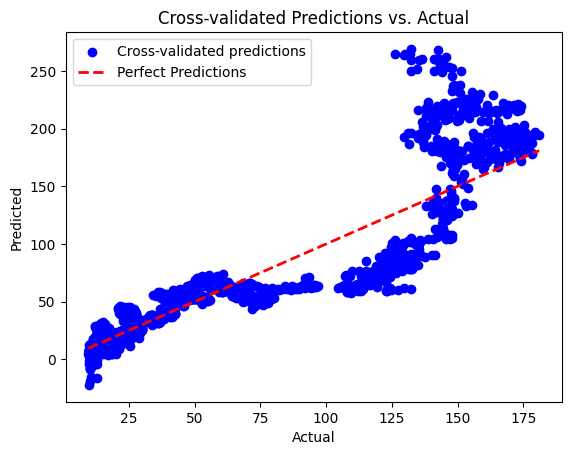

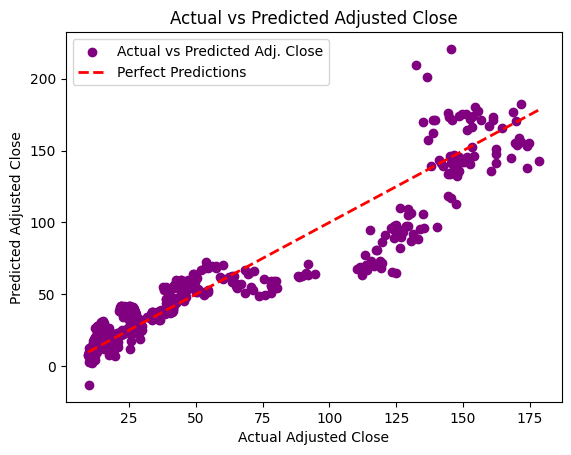

In [22]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

df_aapl = df_aapl.dropna(subset=['Date'])

# Convert the 'Date' column to datetime type
# df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# # Extract the timestamp from the datetime and convert it to float
# df_aapl['Date'] = df_aapl['Date'].apply(lambda x: x.timestamp())

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately 22 business (market open) days later
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-250)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

print("after tail")
print(df_aapl.tail(35))

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (10/23/2018)
custom_values = np.array([[53.957500,55.812500,53.674999,55.682499,155071200,0]])

# This would be the next day after the above date (10/24/2018)
actual_adj_value = 51.719452

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 10/23/2018 predicting 10/24/2018)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print("Custom Predictions:")
print(custom_predictions)

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the results of cross-validated predictions
plt.scatter(y_aapl, predicted, color='blue', label='Cross-validated predictions')
plt.plot([y_aapl.min(), y_aapl.max()], [y_aapl.min(), y_aapl.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Cross-validated Predictions vs. Actual')
plt.legend()
plt.show()

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


#Next Decade Stock Prediction (non-earnings)

Make sure to check that rows are not going off the edge and our data is appropriately scoped.

after tail
           Date       Open       High        Low      Close  Adj Close  \
716  2012-11-06  21.079643  21.097857  20.717501  20.816071  17.820175   
717  2012-11-07  20.494286  20.519285  19.848213  19.928572  17.138319   
718  2012-11-08  20.022499  20.079643  19.117500  19.205357  16.516380   
719  2012-11-09  19.300714  19.817142  19.061428  19.537857  16.802315   
720  2012-11-12  19.791071  19.803572  19.237499  19.386786  16.672400   
721  2012-11-13  19.246786  19.660000  19.155714  19.389286  16.674545   
722  2012-11-14  19.482143  19.551786  19.149286  19.174286  16.489651   
723  2012-11-15  19.197500  19.267857  18.665001  18.772142  16.143816   
724  2012-11-16  18.757143  18.928572  18.062500  18.845715  16.207079   
725  2012-11-19  19.311071  20.267857  19.281429  20.204643  17.375750   
726  2012-11-20  20.425358  20.426786  19.806429  20.032499  17.227705   
727  2012-11-21  20.151787  20.263214  19.878571  20.060715  17.251970   
728  2012-11-23  20.256071 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


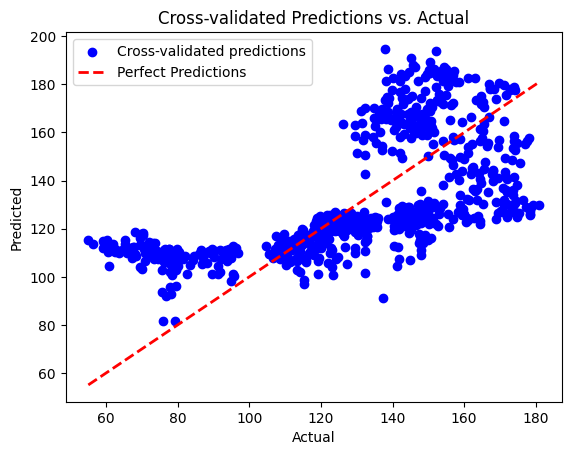

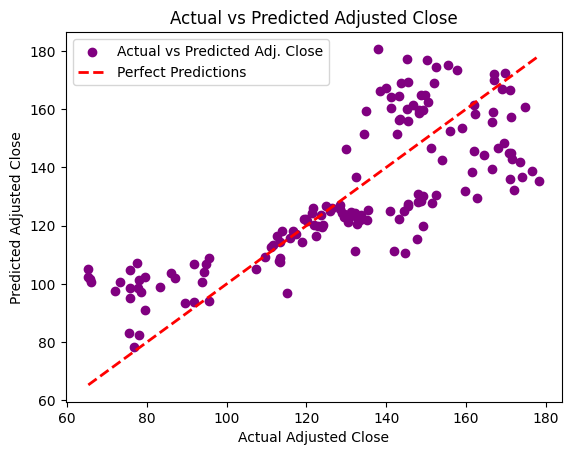

In [23]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

df_aapl = df_aapl.dropna(subset=['Date'])

# Convert the 'Date' column to datetime type
# df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# # Extract the timestamp from the datetime and convert it to float
# df_aapl['Date'] = df_aapl['Date'].apply(lambda x: x.timestamp())

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately 22 business (market open) days later
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-2520)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

print("after tail")
print(df_aapl.tail(35))

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (10/23/2018)
custom_values = np.array([[53.957500,55.812500,53.674999,55.682499,155071200,0]])

# This would be the next day after the above date (10/24/2018)
actual_adj_value = 51.719452

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 10/23/2018 predicting 10/24/2018)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print("Custom Predictions:")
print(custom_predictions)

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the results of cross-validated predictions
plt.scatter(y_aapl, predicted, color='blue', label='Cross-validated predictions')
plt.plot([y_aapl.min(), y_aapl.max()], [y_aapl.min(), y_aapl.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Cross-validated Predictions vs. Actual')
plt.legend()
plt.show()

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


# Random Forest Regressor

**Next Day Prediction (non-earnings eve)**

Uses non-earnings eve rows (ie rows where the next day is not an earnings day) to forecast AAPL stock price predictions for the next day

MSE of RF Regressor (adj price in dollars amount off): 0.056235182897262405
0.056235182897262405
Overall modified Accuracy
0.9855995581182545
Custom Predictions:
[21.25720471]
Accuracy of Custom Prediction:
[41.10098597]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


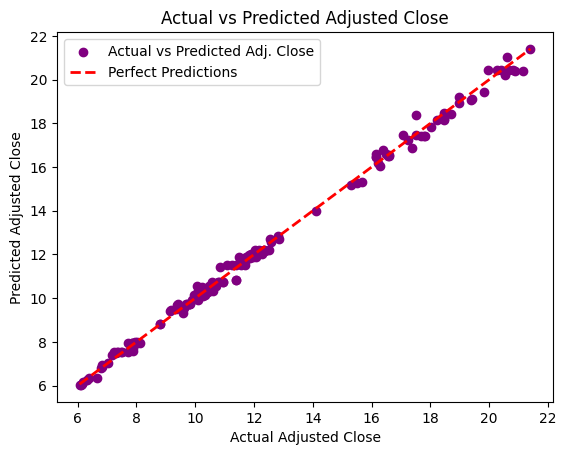

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# Assign the target adj close (what we are trying to predict)
# to be the subsequent row's adjusted close on the following day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-1)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best hyperparameters based on our Grid search exhaustive findings
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))


# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (10/23/2018)
custom_values = np.array([[53.957500,55.812500,53.674999,55.682499,155071200,0]])

# This would be the next day after the above date (10/24/2018)
actual_adj_value = 51.719452

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 10/23/2018 predicting 10/24/2018)
custom_predictions = best_model.predict(custom_values_scaled)

# Print the predictions
print("Custom Predictions:")
print(custom_predictions)

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the results of cross-validated predictions
# plt.scatter(y_aapl, predicted, color='blue', label='Cross-validated predictions')
# plt.plot([y_aapl.min(), y_aapl.max()], [y_aapl.min(), y_aapl.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Cross-validated Predictions vs. Actual')
# plt.legend()
# plt.show()

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Next Day Prediction (earnings eve)**
Uses earnings eve rows and subsequent earnings day rows as pairs to predict the earnings day adjusted price based upon earnings eve

<ipython-input-25-6eb8c9059f14>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(row)
<ipython-input-25-6eb8c9059f14>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(df_aapl.loc[index + 1])
<ipython-input-25-6eb8c9059f14>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(row)
<ipython-input-25-6eb8c9059f14>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(df_aapl.loc[index + 1])
<ipython-input-25-6eb8c9059f14>:27: FutureWarning: The frame.append method is deprecated and will be removed f

MSE of RF Regressor (adj price in dollars amount off): 43.62050443254172
43.62050443254172
Overall modified Accuracy
0.9457600403793232
Custom Predictions:
[50.23834554]
Accuracy of Custom Prediction:
[99.30095536]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


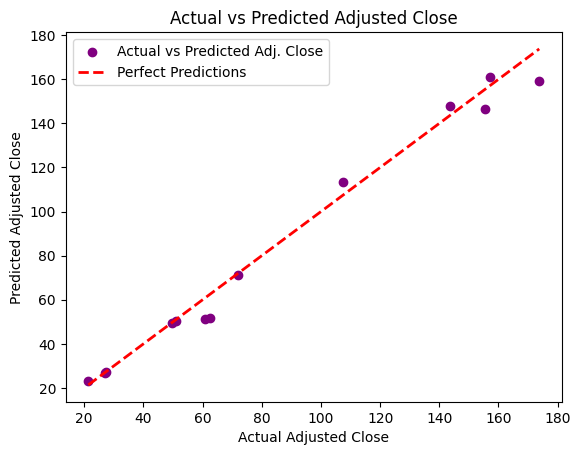

In [25]:
df_aapl = pd.read_csv('AAPL.csv')

df_aapl = df_aapl.dropna(subset=['Date'])

# Convert the 'Date' column to datetime type
# df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# # Extract the timestamp from the datetime and convert it to float
# df_aapl['Date'] = df_aapl['Date'].apply(lambda x: x.timestamp())

# Assign the target adjusted close (ie what we are trying to predict)
# to be the next day's adjusted close
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-1)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Initialize an empty dataframe to store the selected rows (earnings rows and the subsequent row directly after
# so we can see the effect of the earnings results on the stock price the next day)
selected_rows = pd.DataFrame()

# Iterate through the entirety of the aapl dataframe
for index, row in df_aapl.iterrows():
    # Check if the current row has "Earnings" equal to 1
    if row['Earnings'] == 1.0:
        # Append the current row
        selected_rows = selected_rows.append(row)
        # Check if we are still within bounds of the df
        if ((index + 1 < len(df_aapl))):
          # If so, also append the subsequent non-earnings row to our selected rows
          selected_rows = selected_rows.append(df_aapl.loc[index + 1])

# Reset the index of the new DataFrame
selected_rows.reset_index(drop=True, inplace=True)

# Update the aapl df to contain only the selected rows relevant to earnings eve
df_aapl_earn = selected_rows

# Separate the features (X) and target variable (y)
y_aapl = df_aapl_earn['Target Adj Close']

X_aapl = df_aapl_earn.drop(['Adj Close', 'Target Adj Close', 'Date'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best hyperparameters based on our Grid search exhaustive findings
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))


# takes in open, high, low, close, volume, earnings, expected eps, actual eps
# below is an example value of earnings day eve provided as an example (11/01/2018)
custom_values = np.array([[54.762501,55.590000,54.202499,55.555000,233292800,1,0.7,0.73]])

# This would be the next day after the above date (11/02/2018)
actual_adj_value = 49.889595

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 11/01/2018 predicting 11/02/2018 adj close)
custom_predictions = best_model.predict(custom_values_scaled)

# Print the predictions
print("Custom Predictions:")
print(custom_predictions)

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()